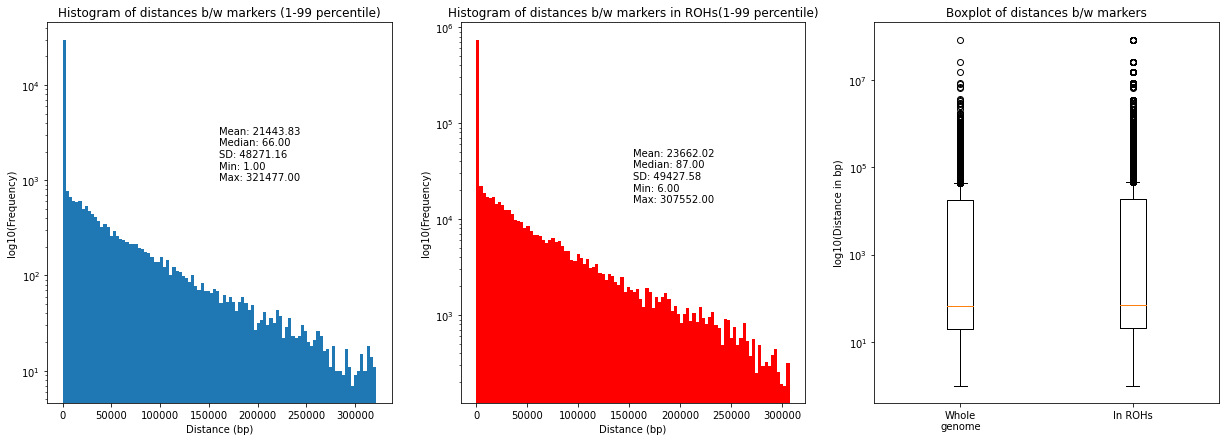

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Mikado.utilities import Interval, IntervalTree
import gzip


markers = dict()

for record in gzip.open("VCF_sorted.ragoo.vcf.gz", "rt"):
    if record.startswith("#"):
        continue
    chrom, start = record.split()[:2]
    start = int(start)
    if chrom not in markers:
        markers[chrom] = []
    markers[chrom].append(start)

distances = []
    
for chrom in markers:
    markers[chrom] = sorted(markers[chrom])
    m = np.sort(np.array(markers[chrom]))
    distances.extend(m[1:] - m[:-1])

distances = np.array(distances)
quant = np.quantile(distances, [.01, .99])
d = distances[np.where((distances >= quant[0]) & (distances <= quant[1]))]

# Create the figure
figure, subplots = plt.subplots(1, 3, figsize=(21, 7))

d = distances[np.where((distances >= np.quantile(distances, [.01, .99])[0]) & (distances <= np.quantile(distances, [.01, .99])[1]))]

plot = subplots[0]
plot.hist(d, bins=100, log=True)
plot.set_title("Histogram of distances b/w markers (1-99 percentile)")
plot.set_ylabel("log10(Frequency)")
plot.set_xlabel("Distance (bp)")
plot.text(d.max() / 2, 1000, "Mean: {:.2f}\nMedian: {:.2f}\nSD: {:.2f}\nMin: {:.2f}\nMax: {:.2f}".format(
    d.mean(), np.median(d), d.std(), d.min(), d.max()))

from Mikado.utilities import Interval, IntervalTree

mtrees = dict()
for chrom in markers:
    mtrees[chrom] = IntervalTree().from_intervals([
        Interval(m, m+1) for m in markers[chrom]
    ])

    
mdists = []

marker_num = {"chrom": [], "start": [], "end": [], "num": []}

with gzip.open("VCF_sorted.ragoo.vcf.bcftools_roh.gz", "rt") as roh:
    for line in roh:
        if line.startswith("#"):
            continue
        chromosome, start, end = line.split()[2:5]
        start, end = int(start), int(end)
        ivs = mtrees[chromosome].search(start, end)
        if len(ivs) == 0:
            raise ValueError(chromosome, start, end)
        ivs = np.sort(np.array([_[0] for _ in ivs]))
        # Distances between markers within the ROH        
        mdists.extend(ivs[1:] - ivs[:-1])
        marker_num["num"].append(len(ivs))
        marker_num["chrom"].append(chromosome)
        marker_num["start"].append(start)
        marker_num["end"].append(end)

import pandas as pd
        
marker_num = pd.DataFrame().assign(**marker_num)

omdists = np.array(mdists)
mquant = np.quantile(omdists, [.1, .99])
mdists = omdists[np.where((omdists >= mquant[0]) & (omdists <=mquant[1]))]
plot = subplots[1]
plot.hist(mdists, bins=100, log=True, color="red")
plot.set_title("Histogram of distances b/w markers in ROHs(1-99 percentile)")
plot.set_ylabel("log10(Frequency)")
plot.set_xlabel("Distance (bp)")
plot.text(mdists.max() / 2, 15000, "Mean: {:.2f}\nMedian: {:.2f}\nSD: {:.2f}\nMin: {:.2f}\nMax: {:.2f}".format(
    mdists.mean(), np.median(mdists), mdists.std(), mdists.min(), mdists.max()))

# Now boxplot

plot = subplots[2]
plot.boxplot([distances, omdists])
plot.set_title("Boxplot of distances b/w markers")
plot.set_xticklabels(["Whole\ngenome", "In ROHs"])
plot.set_ylabel("log10(Distance in bp)")
plot.set_yscale("log")
# plt.savefig("Distances.png", dpi=1000)
# plt.savefig("Distances.svg", dpi=1000)

['<=0.017\n(1.0%)', '0.017 - 23.7\n(1.0 - 2.0%)', '23.7 - 1,515.1\n(2.0 - 50.0%)', '1,515.1 - 601.3\n(50.0 - 20.0%)', '601.3 - 1,127.6\n(20.0 - 40.0%)', '1,127.6 - 1,975.5\n(40.0 - 60.0%)', '1,975.5 - 4,155.9\n(60.0 - 80.0%)', '4,155.9 - 13,123.7\n(80.0 - 95.0%)', '13,123.7 - 26,721.7\n(95.0 - 98.0%)', '26,721.7 - 35,482.1\n(98.0 - 99.0%)', '>35,482.1\n(99.0%)']


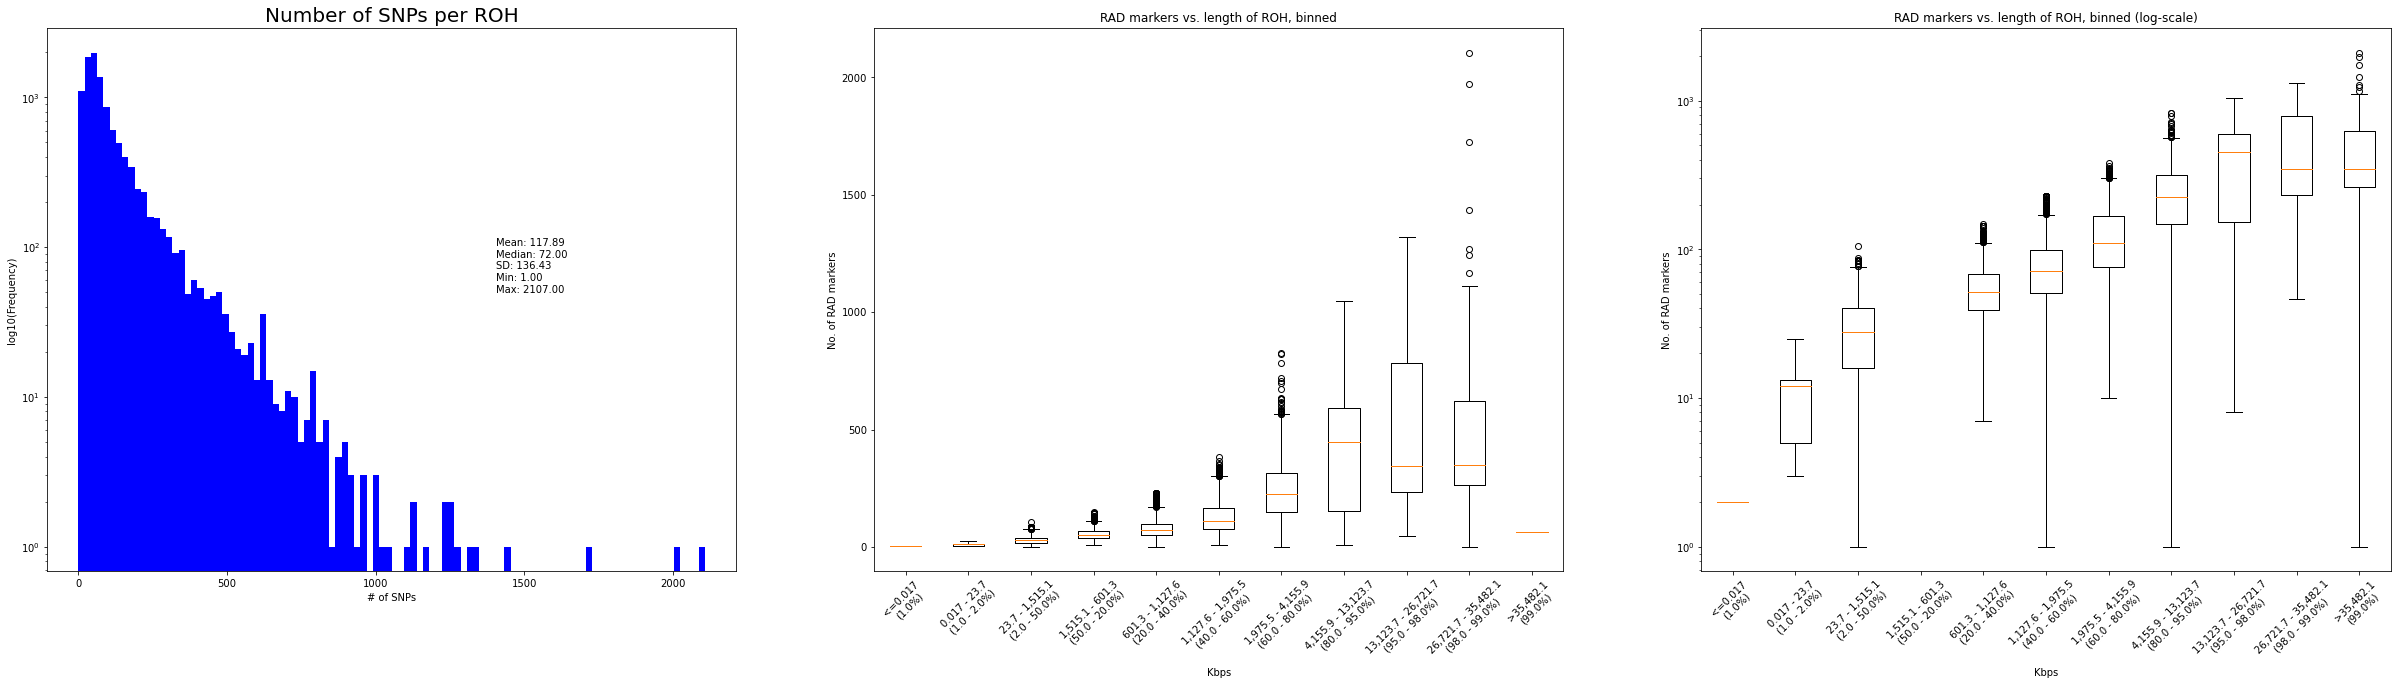

In [7]:
# No. of markers per ROH

figure, axes = plt.subplots(1, 3, figsize=(42, 10))

roh = pd.read_csv("VCF_sorted.ragoo.vcf.bcftools_roh.gz",
                  compression="gzip", delimiter="\t",
                  comment="#", names=["RG", "sample", "chromosome", "start", "end", "length", "markers", "quality"])

roh["imputed"] = roh.eval("end - start + 1")
assert not (roh["imputed"] != roh["length"]).any(), roh[["length", "imputed"]].head()

_quantiles = [.01, .02, .5, .2, .4, .6, .8, .95, .98, .99, 1.00]

q = np.quantile(roh["length"].values, q=_quantiles)

for index in roh.index.values:
    l = roh.loc[index, "length"]
    if l < q[0]:
        roh.loc[index, "bin"] = 0
    else:
        binned = np.where(l >= q)[0].max() + 1
        if binned == len(q) + 1:
            binned -= 1
        roh.loc[index, "bin"] = binned
        
        
assert roh["bin"].max() == len(q)
        
marker_num_arr = marker_num.num.values
plot = axes[0]
plot.set_title("Number of SNPs per ROH", size=20)
plot.hist(marker_num_arr, bins=100, log=True, color="blue")
plot.set_ylabel("log10(Frequency)")
plot.set_xlabel("# of SNPs")
plot.text(marker_num_arr.max() * 2/3, 50, "Mean: {:.2f}\nMedian: {:.2f}\nSD: {:.2f}\nMin: {:.2f}\nMax: {:.2f}".format(
    marker_num_arr.mean(), np.median(marker_num_arr), marker_num_arr.std(), marker_num_arr.min(), marker_num_arr.max()))


aq = q / 1000
ax = axes[1]
ax.boxplot([roh.query("bin == @binned")["markers"] for binned in sorted(roh["bin"].unique())])
# ax.set_xticklabels(["1-20%", "20-40%", "40-60%", "60-80%", "80-99%", "99%"])

xticks = [f"<={aq[0]:,.3f}\n({_quantiles[0] * 100}%)"]
for pos in range(len(aq) - 2):
    if aq[pos] < 1:
        xticks.append(f"{aq[pos]:,.3f} - {aq[pos + 1]:,.1f}\n({_quantiles[pos] * 100} - {_quantiles[pos + 1] * 100}%)")
    else:
        xticks.append(f"{aq[pos]:,.1f} - {aq[pos + 1]:,.1f}\n({_quantiles[pos] * 100} - {_quantiles[pos + 1] * 100}%)")
xticks.append(f">{aq[-2]:,.1f}\n({_quantiles[-2] * 100}%)")

print(xticks)
ax.set_xticklabels(xticks)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel("Kbps")
ax.set_ylabel("No. of RAD markers")
ax.set_title("RAD markers vs. length of ROH, binned")

ax = axes[2]
ax.boxplot([roh.query("bin == @binned")["markers"] for binned in range(len(xticks))])
ax.set_xticklabels(xticks)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel("Kbps")
ax.set_ylabel("No. of RAD markers")
ax.set_yscale("log")
ax.set_title("RAD markers vs. length of ROH, binned (log-scale)")

# plt.savefig("Markers_per_ROH.png", dpi=1000)
plt.savefig("Markers_per_ROH.svg", dpi=1000)

In [3]:
roh.head()

,RG,sample,chromosome,start,end,length,markers,quality,imputed,bin
0,RG,Q41_adapt_filt_sbfi_filt_6-22748_R1adapt_filt_...,1_RaGOO,2025286,3730652,1705367,60,14.0,1705367,5.0
1,RG,Q41_adapt_filt_sbfi_filt_6-22748_R1adapt_filt_...,1_RaGOO,6454687,7897686,1443000,58,48.1,1443000,5.0
2,RG,Q41_adapt_filt_sbfi_filt_6-22748_R1adapt_filt_...,1_RaGOO,44337934,48625379,4287446,196,59.2,4287446,7.0
3,RG,Q41_adapt_filt_sbfi_filt_6-22748_R1adapt_filt_...,1_RaGOO,62138218,71826524,9688307,396,63.1,9688307,7.0
4,RG,Q41_adapt_filt_sbfi_filt_6-22748_R1adapt_filt_...,1_RaGOO,111727448,114092861,2365414,66,32.2,2365414,6.0
